# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

## Data

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import random
from torch.utils.data import random_split
from torchvision import transforms
import gc
from torchvision.models.detection import _utils as d_utils

Install library for processing the labeling
```bash
pip install xmltodict
```

In [2]:
import xmltodict, json

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [5]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, class2tag, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            return self.transform(self.images[i]), self.annotations[i]
#             res = self.transform(
#                 image=self.images[i],
#                 bboxes=self.annotations[i]["boxes"],
#                 labels=self.annotations[i]["labels"],
#             )
#             return res["image"], {
#                 "boxes": torch.tensor(res["bboxes"]),
#                 "labels": torch.tensor(res["labels"]),
#             }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

<br>  
<br>  
Функции для вычисления mAP.

In [135]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    
    
    dt_labels = np.where(dt_labels == 52, 1, dt_labels) 
    dt_labels = np.where(dt_labels == 53, 1, dt_labels) 
    dt_labels = np.where(dt_labels == 55, 1, dt_labels) 
#     an_array = np.where(an_array > 20, 0, an_array)

    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device, iou_threshold=0.5):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true, iou_threshold=iou_threshold))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

In [7]:
all_classes_the_same = {"apple": 1, "orange": 1, "banana": 1}

In [8]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [9]:
ds_train_all = FruitDataset("train", all_classes_the_same, transform)
train_size = round(len(ds_train_all)*0.75)
val_size = len(ds_train_all) - train_size
print(val_size, train_size)

ds_val, ds_train = random_split(ds_train_all, [val_size, train_size])
ds_test = FruitDataset("test", all_classes_the_same, transform)

60 180


In [10]:
batch_size=1

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=lambda data: tuple(zip(*data)))
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, collate_fn=lambda data: tuple(zip(*data)))
dl_test = DataLoader(ds_test, batch_size=batch_size, collate_fn=lambda data: tuple(zip(*data)))

In [88]:
def get_model(name="faster_rcnn", num_classes=2, pretrained=True, add_new_head=False):
    if name == "faster_rcnn":
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=pretrained)
        if add_new_head:
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    elif name == "retina":
        model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=pretrained)
        if add_new_head:
            in_features = model.head.classification_head.conv[0].in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
                num_anchors=num_anchors,
                in_channels=in_features,
                num_classes=num_classes,
            )
    elif name == "ssd":
        model = torchvision.models.detection.ssd300_vgg16(pretrained=pretrained)
        if add_new_head:
            num_anchors = model.anchor_generator.num_anchors_per_location()
            out_channels = d_utils.retrieve_out_channels(model.backbone, (300, 300))
            model.head.classification_head = torchvision.models.detection.ssd.SSDClassificationHead(
                in_channels=out_channels,
                num_anchors=num_anchors,
                num_classes=num_classes,
            )
    return model.to(device)

In [256]:
def draw_bboxes(image, bboxes, scores=None, score=None, labels=None):
    image = prepair_img(image)
    r = [(255, 255, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0)]
    for i, bbox in enumerate(bboxes):
        color = r[labels[i].item()] if not labels is None else (0, 255, 255)
        if not scores is None and scores[i] > score:
            image = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 3)
        elif scores is None:
            image = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 3)
    return image
    
def prepair_img(image):
    image = image.numpy()*255
    return np.ascontiguousarray(np.moveaxis(image, 0, 2), dtype=np.uint8) 


def watch_predict(model, i=None, ds=None, im=None, boxes=None, labels=None,  pred=None, score=0, iou_tresh=0, perform_nms=False):
    if im is None:
        im = ds[i][0]
        boxes = ds[i][1]["boxes"]
        labels = ds[i][1]["labels"]
        pred = model([ds[i][0].to(device)])[0]
    elif not im is None and pred is None:
        pred = model([im.to(device)])[0]
    pred_boxes = pred['boxes']
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5, forward=True)
    im1 = draw_bboxes(im, boxes, labels=labels)
    new_pred_boxes, scores, labels = [], [], []
    if perform_nms:
        new_pred_boxes, scores, labels = nms(pred_boxes, pred["scores"], iou_tresh)
    else:
        for box in boxes:
            for j, p_box in enumerate(pred_boxes):
                with torch.no_grad():
                    iou = intersection_over_union(box.cpu(), p_box.cpu())
                    if iou > iou_tresh:
                        new_pred_boxes.append(p_box.cpu())
                        scores.append(pred["scores"][j])
                        labels.append(pred["labels"][j])
        if new_pred_boxes:
            new_pred_boxes = torch.stack(new_pred_boxes)
    im2 = draw_bboxes(im, new_pred_boxes, scores, score, labels)
    ax1.imshow(im1)
    ax1.set_title("target")
    ax2.imshow(im2)
    ax2.set_title(f"predicted | score: {score} | iou: {iou_tresh}")
    plt.show()


def watch_predictions(model, loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            pred = model([x.to(device) for x in images])
            for i, _  in enumerate(images):
                watch_predict(model, im=images[i], boxes=targets[i]['boxes'], pred=pred[i])

In [33]:
def clear_cuda(dataset=None, model=None):
    try:
        del dataset
        del model
    except Exception:
        pass
    gc.collect()
    torch.cuda.empty_cache()

In [250]:
def check_model(im, boxes, name="faster_rcnn", num_classes=2, pretrained=True, add_new_head=False, model=None, dl=dl_test, score=0, iou_tresh=0, labels=None):
    if not model:
        model = get_model(name, num_classes, pretrained, add_new_head)
    print(f"AUC = {evaluate(model, dl, device)}")
    watch_predict(model, im=im, boxes=boxes, labels=labels, score=score, iou_tresh=iou_tresh)
    clear_cuda()

AUC = 0.6016878682286823


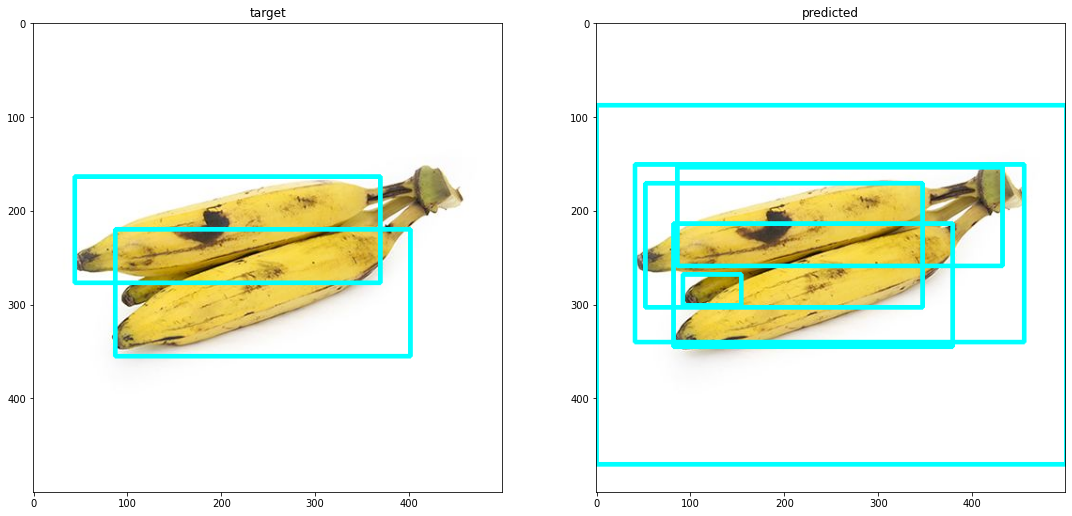

In [73]:
check_model(ds_test[0][0], ds_test[0][1]["boxes"],"faster_rcnn", 2, True, dl=dl_test)

AUC = 0.5176670295053837


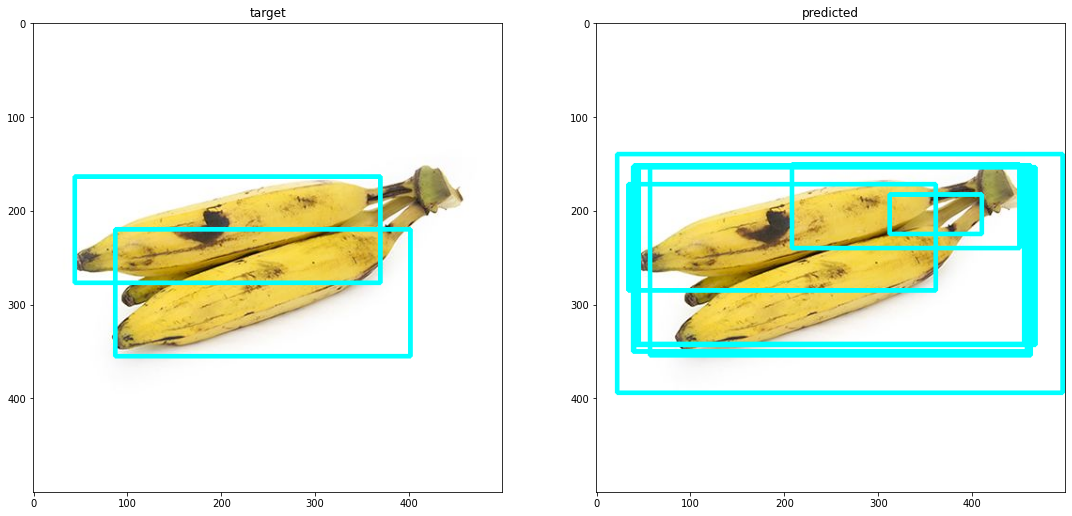

In [74]:
check_model(ds_test[0][0], ds_test[0][1]["boxes"],"retina", 2, True, dl=dl_test)

AUC = 0.5822325924135471


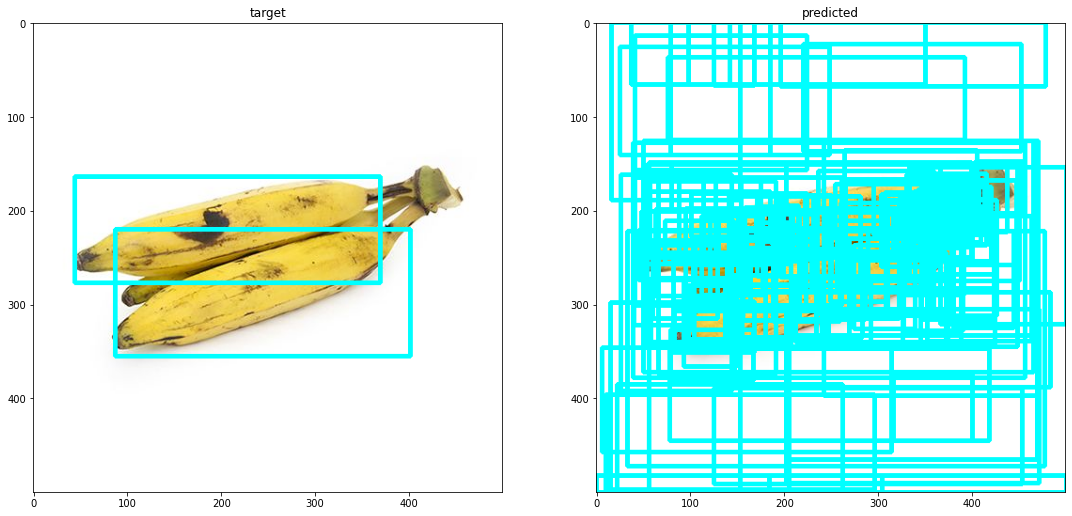

In [75]:
check_model(ds_test[0][0], ds_test[0][1]["boxes"],"ssd", 2, True, dl=dl_test)

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

In [84]:
def train_loop(model, epochs, train_dataloader, val_dataloader, optimizer, lr_scheduler=None, save_best_model=False, epoch_print_frequency=1):
    log = {'loss': None,
           'accuracy': None, 
           'best_epoch': None}

    model.to(device)
    for epoch in range(epochs):
        # Train
        model.train()
        for X, y in train_dataloader:
            X, y = [x.to(device) for x in X], [{k: v.to(device) for k, v in _.items()} for _ in y]

            loss = model(X, y)
            
            losses = sum([v for v in loss.values()])
            optimizer.zero_grad()
            losses.backward()

            optimizer.step()
#             lr_scheduler.step()

        #Validation
        auc = evaluate(model, dl_val, device)
        if not log['accuracy']:
            log['accuracy'] = auc
        else:
            if log['accuracy'] < auc:
                log['accuracy'] = auc
        print(f"Epoch: {epoch} / {epochs} | Auc: {auc}  |  Loss: {losses}")
            

        if not log['best_epoch']:
            if save_best_model:
                torch.save(model.state_dict(), 'best_model.pt')
            log['best_epoch'] = epoch

    return log

In [103]:
def train_model(model, lr=0.005, weight_decay=0.0005, num_epochs=3):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, weight_decay=weight_decay)
    log = train_loop(model, num_epochs, dl_train, dl_val, optimizer)
#     print()

In [245]:
def compare_pretrained_and_not_models(name, im=ds_test[0][0], boxes=ds_test[0][1]["boxes"], lr=0.005, num_classes=2, labels=ds_test[0][1]["labels"]):
    model = get_model(name, num_classes=num_classes, pretrained=True, add_new_head=True)
    train_model(model, lr=lr)
    check_model(im, boxes, model=model, dl=dl_test, labels=labels)
    
    model = get_model(name, num_classes=num_classes, pretrained=False, add_new_head=True)
    train_model(model, lr=lr)
    check_model(im, boxes, model=model, dl=dl_test, labels=labels)

Epoch: 0 / 3 | Auc: 0.8460192415986731  |  Loss: 0.9348023533821106
Epoch: 1 / 3 | Auc: 0.9063814227585024  |  Loss: 0.9492835402488708
Epoch: 2 / 3 | Auc: 0.9299632881181411  |  Loss: 0.8320600986480713
AUC = 0.9138645999081926


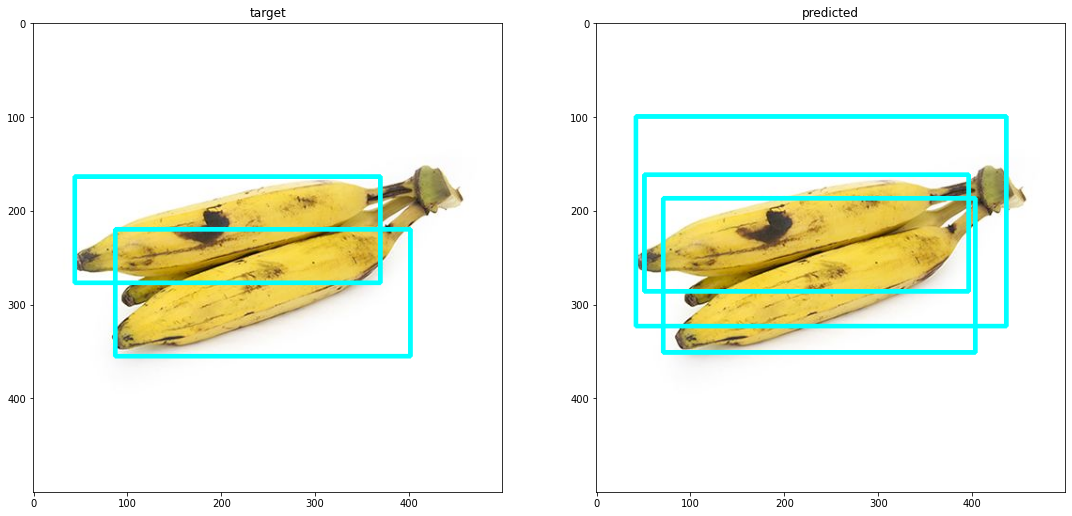

Epoch: 0 / 3 | Auc: 0.28252621396785327  |  Loss: 0.6238779425621033
Epoch: 1 / 3 | Auc: 0.5190415061685345  |  Loss: 0.5371240377426147
Epoch: 2 / 3 | Auc: 0.5598685054818572  |  Loss: 0.48088711500167847
AUC = 0.6522031059374048


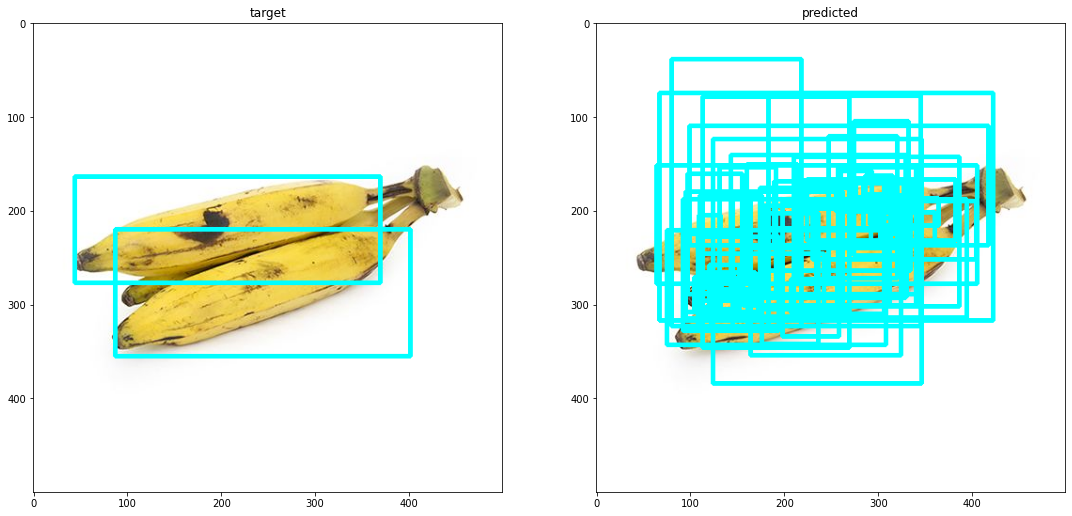

In [107]:
compare_pretrained_and_not_models("faster_rcnn")

In [112]:
compare_pretrained_and_not_models("retina", lr=0.0001)

IndexError: list index out of range

Epoch: 0 / 3 | Auc: 0.7250690146694864  |  Loss: 3.248713970184326
Epoch: 1 / 3 | Auc: 0.8027138761288319  |  Loss: 1.8548954725265503
Epoch: 2 / 3 | Auc: 0.8115078483186475  |  Loss: 1.0631650686264038
AUC = 0.8207134173080463


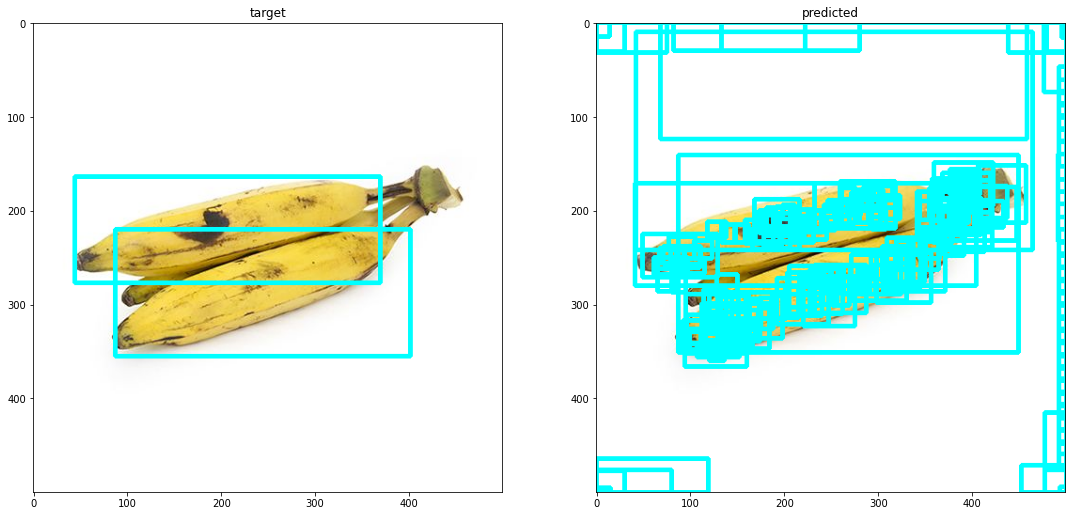

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot.pth


  0%|          | 0.00/56.1M [00:00<?, ?B/s]

Epoch: 0 / 3 | Auc: 0.09552495761225782  |  Loss: nan
Epoch: 1 / 3 | Auc: 0.10154711023179717  |  Loss: nan
Epoch: 2 / 3 | Auc: 0.10366537290691065  |  Loss: nan
AUC = 0.10777850175530594


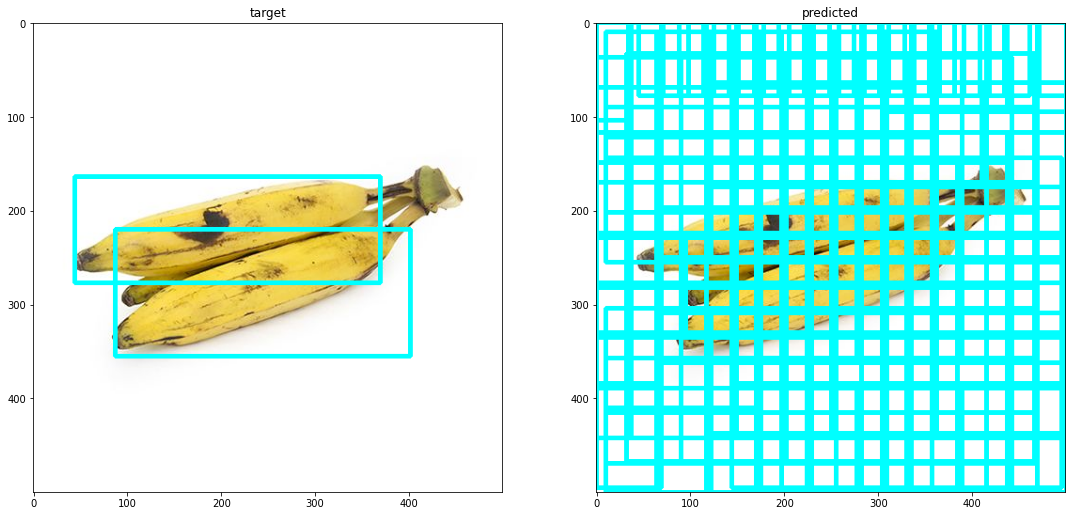

In [114]:
compare_pretrained_and_not_models("ssd", lr=0.001)

### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

In [115]:
model = get_model(name="faster_rcnn", num_classes=2, pretrained=True, add_new_head=True)
train_model(model, num_epochs=6)

Epoch: 0 / 6 | Auc: 0.8441846893348407  |  Loss: 0.4497165083885193
Epoch: 1 / 6 | Auc: 0.9021242587955991  |  Loss: 0.486110121011734
Epoch: 2 / 6 | Auc: 0.9126692463689315  |  Loss: 0.3956429660320282
Epoch: 3 / 6 | Auc: 0.92053856793714  |  Loss: 0.29251042008399963
Epoch: 4 / 6 | Auc: 0.9440510708530695  |  Loss: 0.36346226930618286
Epoch: 5 / 6 | Auc: 0.9147999984760274  |  Loss: 0.41799232363700867


0.9630042322107929


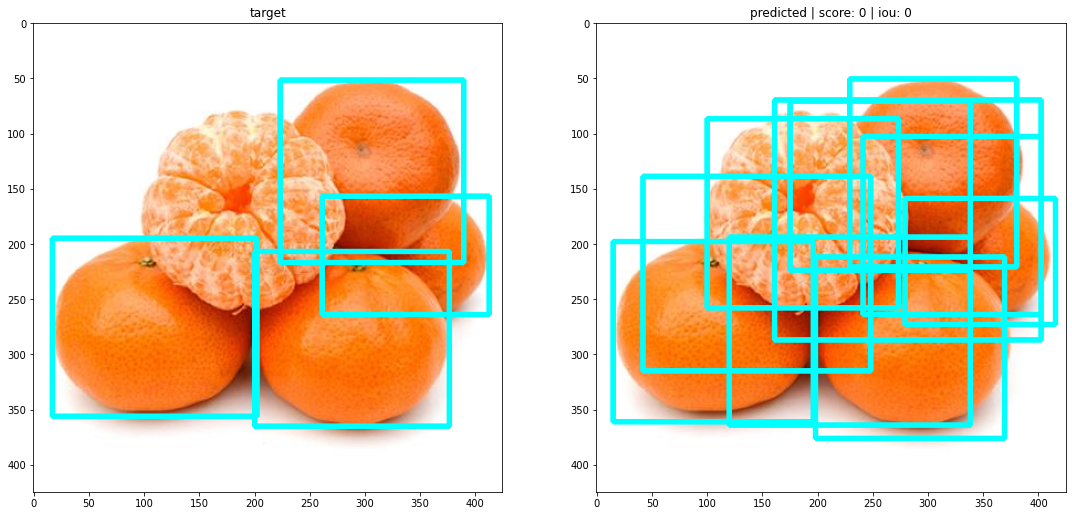

0.9614837971868921


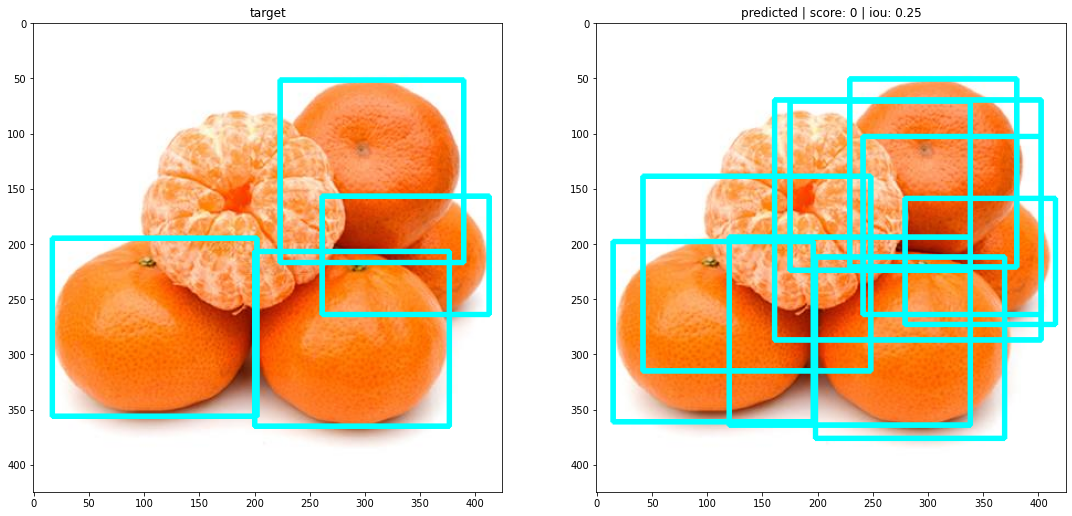

0.9407539011090049


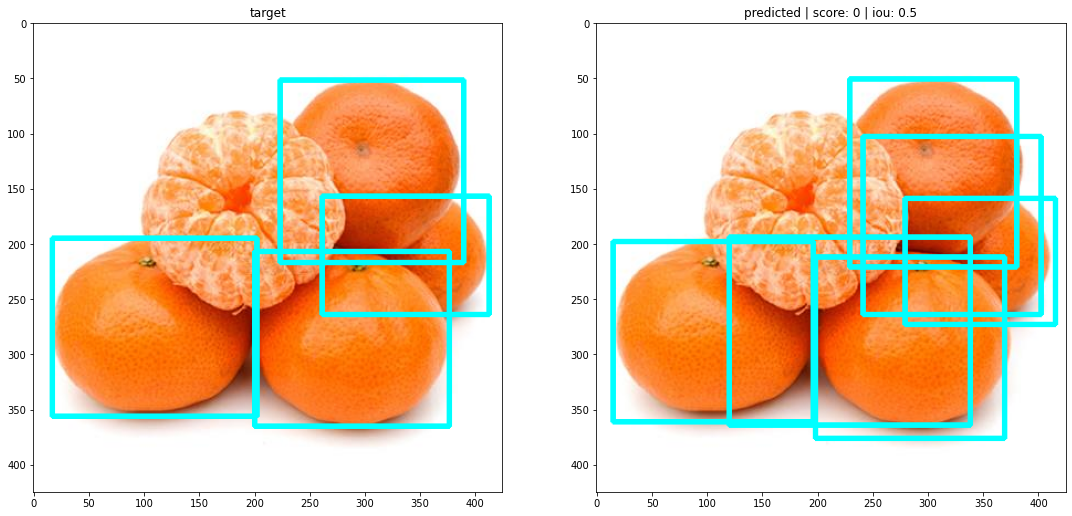

0.7495024574096811


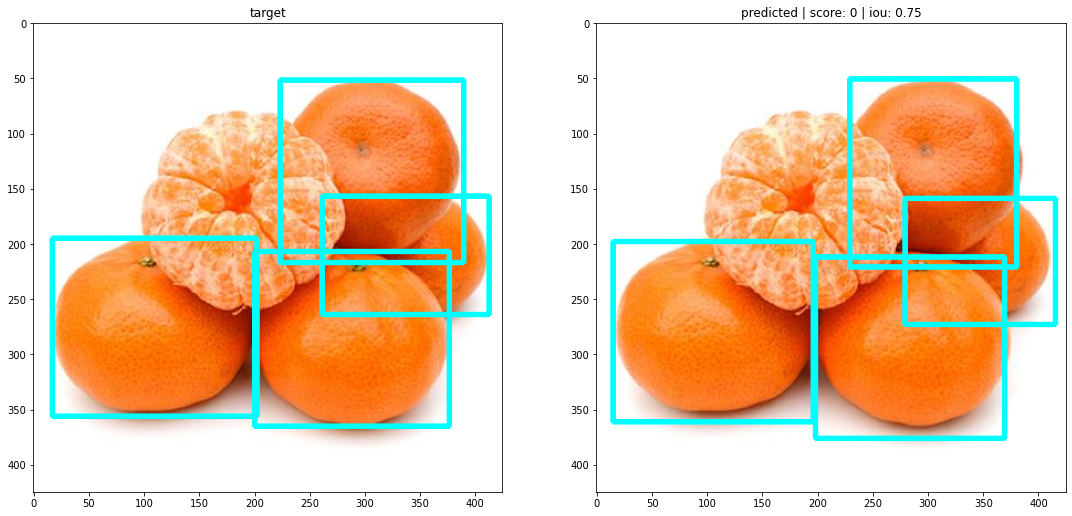

0.0


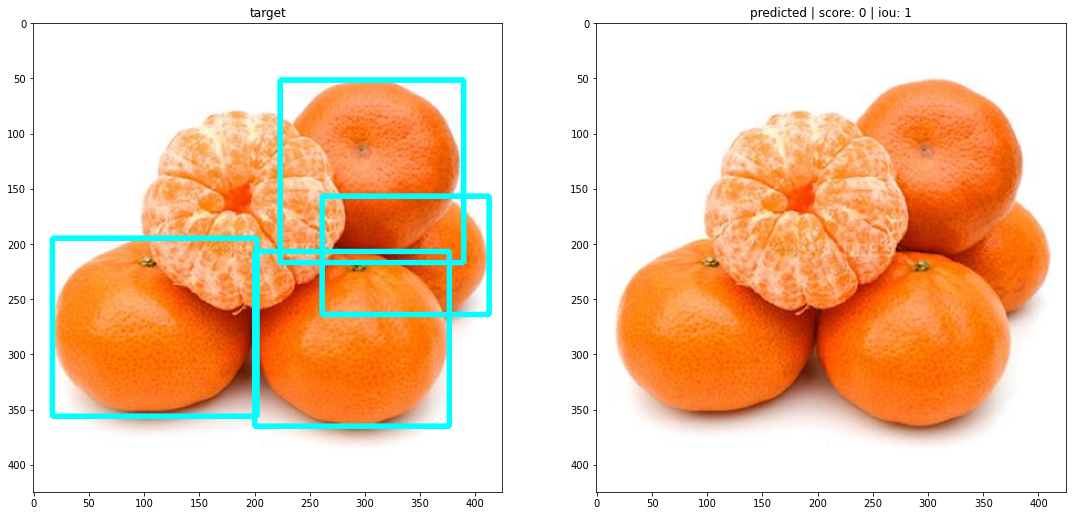

In [146]:
for i in [0, 0.25, 0.5, 0.75, 1]:
    print(evaluate(model, dl_test, device, i))
    watch_predict(model, im=ds_test[5][0], boxes=ds_test[5][1]["boxes"], score=0, iou_tresh=i)

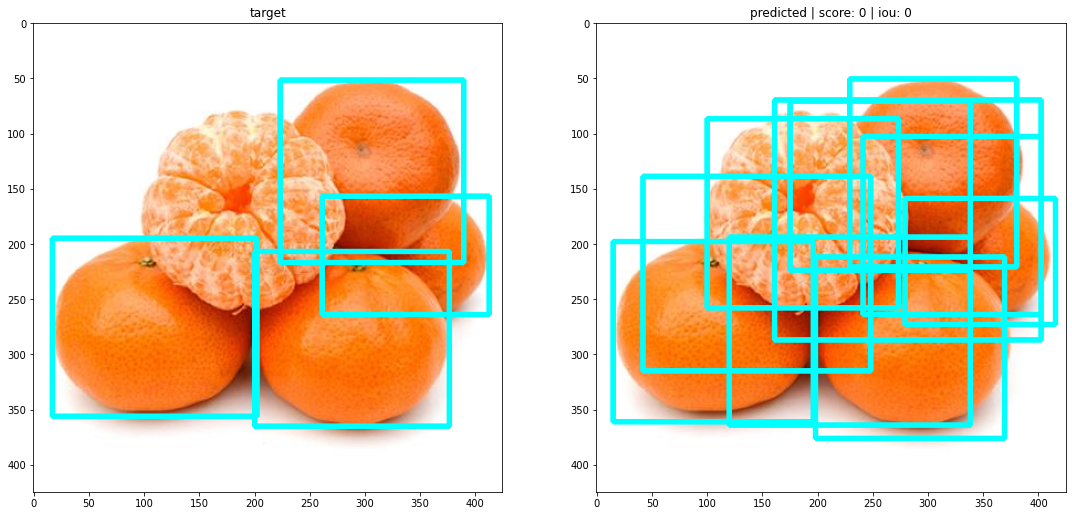

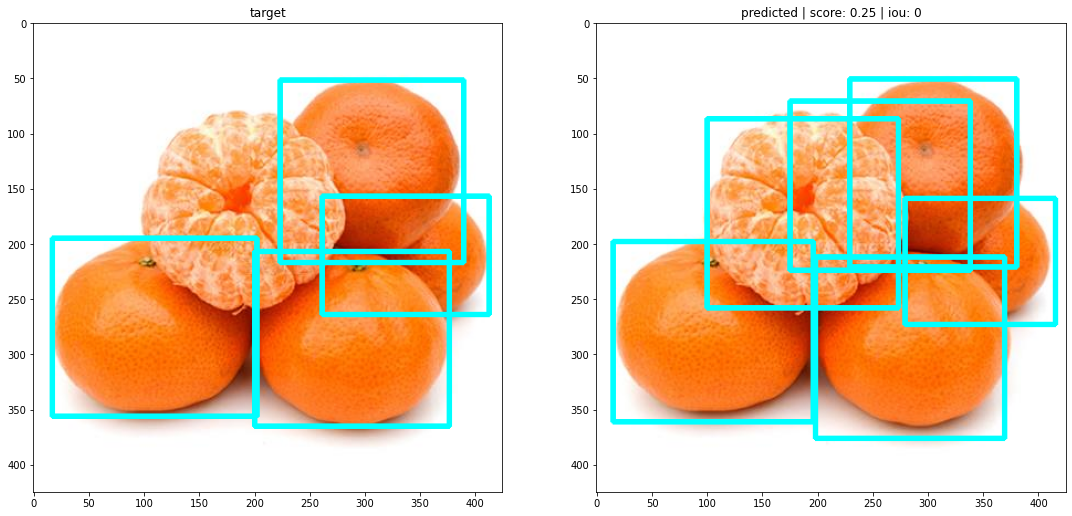

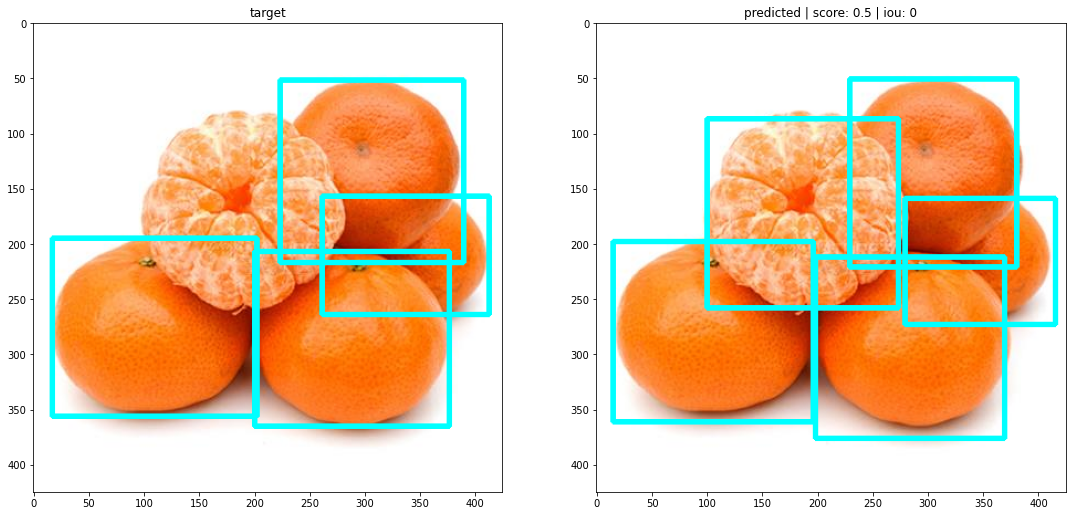

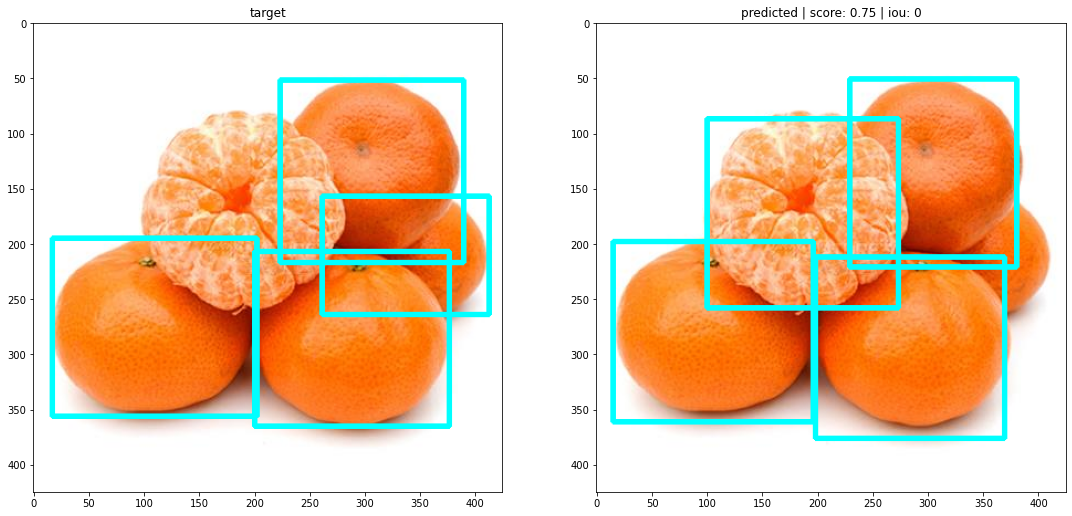

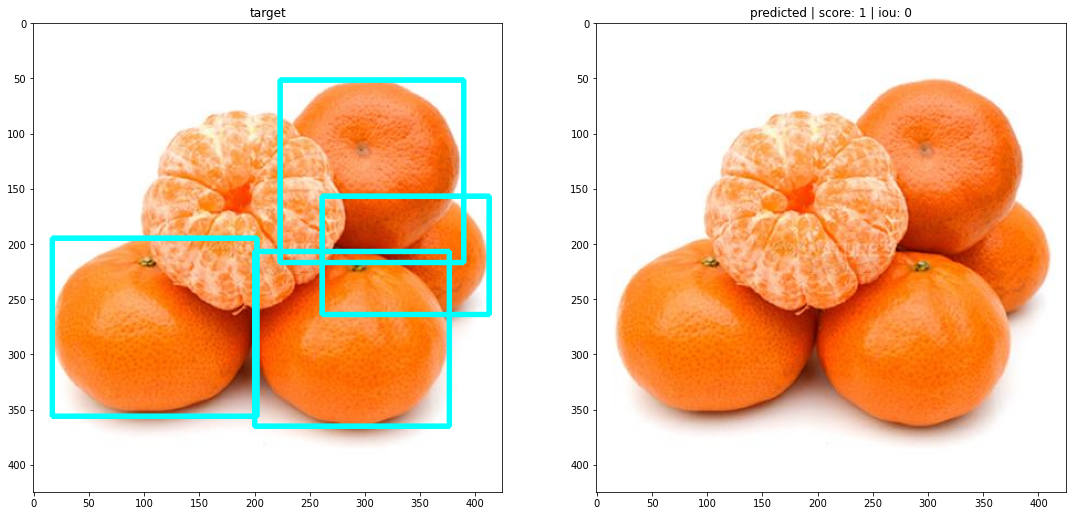

In [147]:
for i in [0, 0.25, 0.5, 0.75, 1]:
    watch_predict(model, im=ds_test[5][0], boxes=ds_test[5][1]["boxes"], score=i, iou_tresh=0)

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

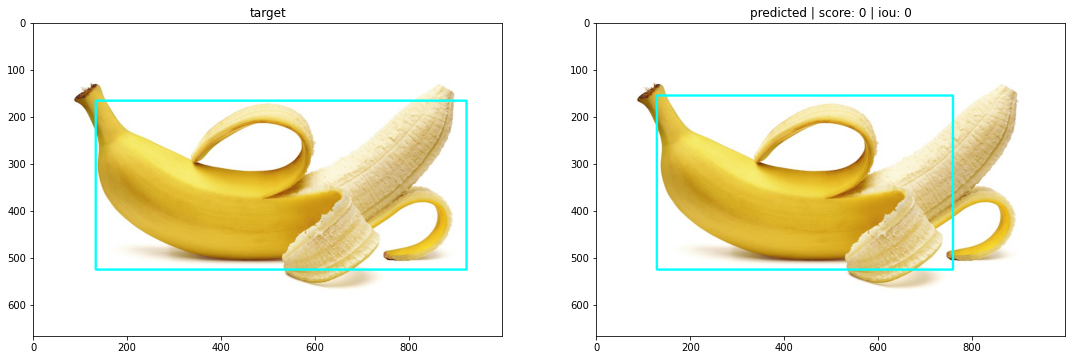

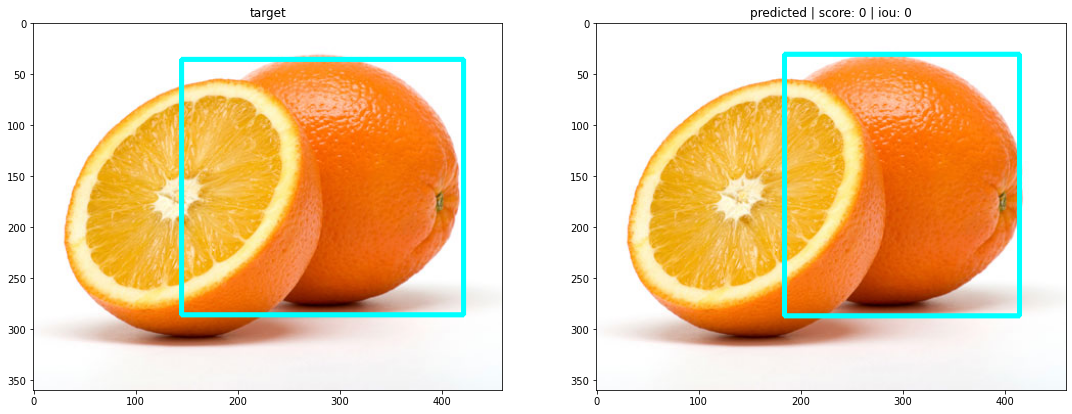

In [148]:
for i in range(10, 12):
    watch_predict(model, im=ds_test[i][0], boxes=ds_test[i][1]["boxes"], score=0, iou_tresh=0)

In [161]:
!wget http://service.volkswagen.ru/eshop/uploads//items/caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg

--2021-12-20 04:36:09--  http://service.volkswagen.ru/eshop/uploads//items/caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg
Resolving service.volkswagen.ru (service.volkswagen.ru)... 78.155.199.182, 193.23.96.7, 194.114.63.2
Connecting to service.volkswagen.ru (service.volkswagen.ru)|78.155.199.182|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://service.volkswagen.ru/eshop/uploads//items/caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg [following]
--2021-12-20 04:36:09--  https://service.volkswagen.ru/eshop/uploads//items/caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg
Connecting to service.volkswagen.ru (service.volkswagen.ru)|78.155.199.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317557 (310K) [image/jpeg]
Saving to: ‘caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg’

caf5e74ebb8ce12af51 100%[===================>] 310.11K  --.-KB/s    in 0.05s   

2021-12-20 04:36:09 (6.02 MB/s) - ‘caf5e74ebb8ce12af51fd48ddd8614848e

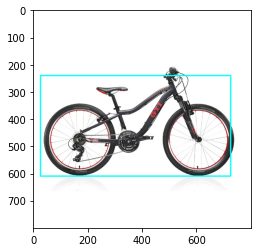

In [162]:
im = cv2.cvtColor(cv2.imread("caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [163]:
!wget https://www.notebookcheck-ru.com/fileadmin/Notebooks/Apple/MacBook_Air_2020_i3/IMG_8048.JPG

--2021-12-20 04:36:48--  https://www.notebookcheck-ru.com/fileadmin/Notebooks/Apple/MacBook_Air_2020_i3/IMG_8048.JPG
Resolving www.notebookcheck-ru.com (www.notebookcheck-ru.com)... 172.67.74.243, 104.26.13.15, 104.26.12.15, ...
Connecting to www.notebookcheck-ru.com (www.notebookcheck-ru.com)|172.67.74.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948591 (926K) [image/jpeg]
Saving to: ‘IMG_8048.JPG.1’

IMG_8048.JPG.1      100%[===================>] 926.36K  --.-KB/s    in 0.1s    

2021-12-20 04:36:49 (6.99 MB/s) - ‘IMG_8048.JPG.1’ saved [948591/948591]



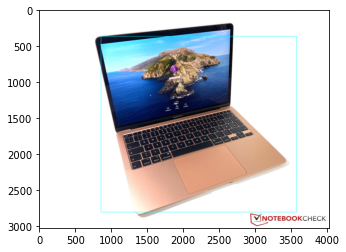

In [160]:
im = cv2.cvtColor(cv2.imread("IMG_8048.JPG"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [165]:
!wget https://www.gettyimages.com/gi-resources/images/500px/983794168.jpg

--2021-12-20 04:38:04--  https://www.gettyimages.com/gi-resources/images/500px/983794168.jpg
Resolving www.gettyimages.com (www.gettyimages.com)... 52.85.49.15, 52.85.49.101, 52.85.49.27, ...
Connecting to www.gettyimages.com (www.gettyimages.com)|52.85.49.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98468 (96K) [image/jpeg]
Saving to: ‘983794168.jpg’

983794168.jpg       100%[===================>]  96.16K   321KB/s    in 0.3s    

2021-12-20 04:38:05 (321 KB/s) - ‘983794168.jpg’ saved [98468/98468]



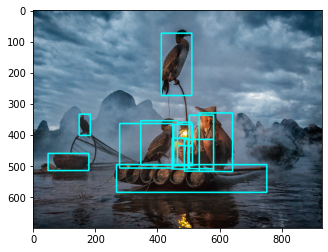

In [167]:
im = cv2.cvtColor(cv2.imread("983794168.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [169]:
!wget https://lenta.gcdn.co/globalassets/1/-/04/30/27/293773.png

--2021-12-20 04:39:39--  https://lenta.gcdn.co/globalassets/1/-/04/30/27/293773.png
Resolving lenta.gcdn.co (lenta.gcdn.co)... 92.223.99.99, 92.223.100.101, 92.223.77.101
Connecting to lenta.gcdn.co (lenta.gcdn.co)|92.223.99.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 904960 (884K) [image/png]
Saving to: ‘293773.png’

293773.png          100%[===================>] 883.75K  --.-KB/s    in 0.1s    

2021-12-20 04:39:39 (8.99 MB/s) - ‘293773.png’ saved [904960/904960]



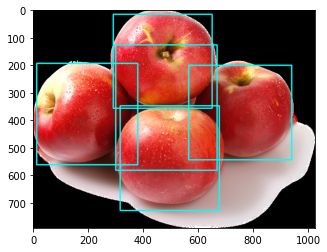

In [170]:
im = cv2.cvtColor(cv2.imread("293773.png"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [173]:
!wget https://cdn.profile.ru/wp-content/uploads/2021/04/oranges-apelsiny-na-vetke.jpg

--2021-12-20 04:41:18--  https://cdn.profile.ru/wp-content/uploads/2021/04/oranges-apelsiny-na-vetke.jpg
Resolving cdn.profile.ru (cdn.profile.ru)... 92.223.99.99
Connecting to cdn.profile.ru (cdn.profile.ru)|92.223.99.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69505 (68K) [image/jpeg]
Saving to: ‘oranges-apelsiny-na-vetke.jpg’

oranges-apelsiny-na 100%[===================>]  67.88K  --.-KB/s    in 0.009s  

2021-12-20 04:41:18 (7.31 MB/s) - ‘oranges-apelsiny-na-vetke.jpg’ saved [69505/69505]



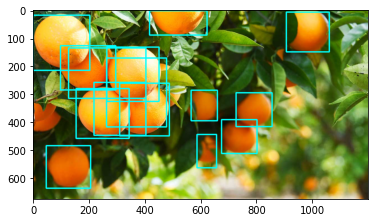

In [174]:
im = cv2.cvtColor(cv2.imread("oranges-apelsiny-na-vetke.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

In [222]:
def nms(boxes, scores, labels, thresh_iou):
    new_labels = []
    P = torch.stack([torch.cat((b, torch.stack([scores[i]]))) for i, b in enumerate(boxes)])
    
    
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    scores = P[:, 4]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()

    keep = []
    

    while len(order) > 0:
        idx = order[-1]
        keep.append(P[idx])
        new_labels.append(labels[idx])
        order = order[:-1]

        if len(order) == 0:
            break
        
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        w = xx2 - xx1
        h = yy2 - yy1
        
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        inter = w*h

        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        union = (rem_areas - inter) + areas[idx]
        
        IoU = inter / union

        mask = IoU < thresh_iou
        order = order[mask]
    
    boxes, scores = [], []
    for b in keep:
        box, score = torch.split(b, [4,1])
        boxes.append(box)
        scores.append(score[0])
    boxes = torch.stack(boxes)
    scores = torch.stack(scores)
    return boxes, scores, new_labels

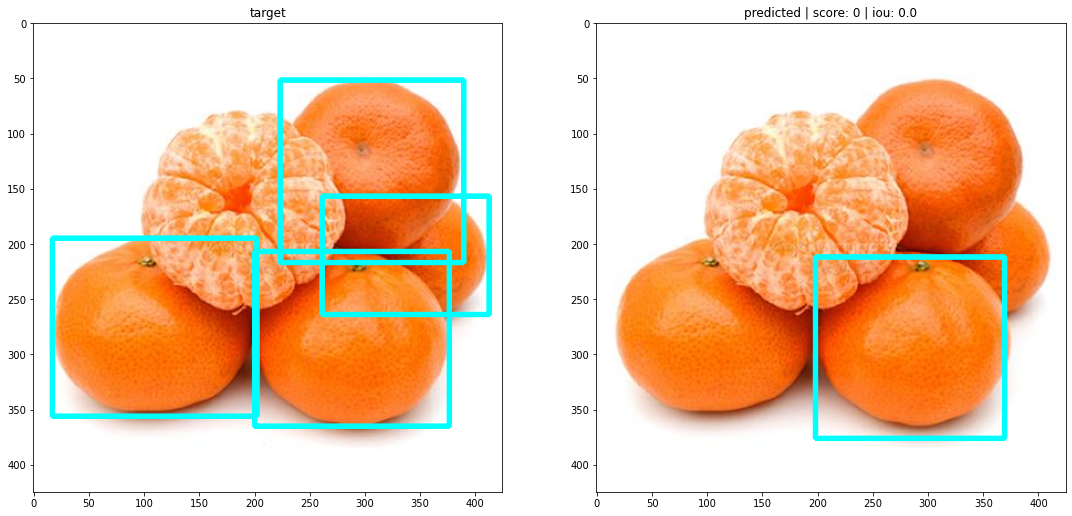

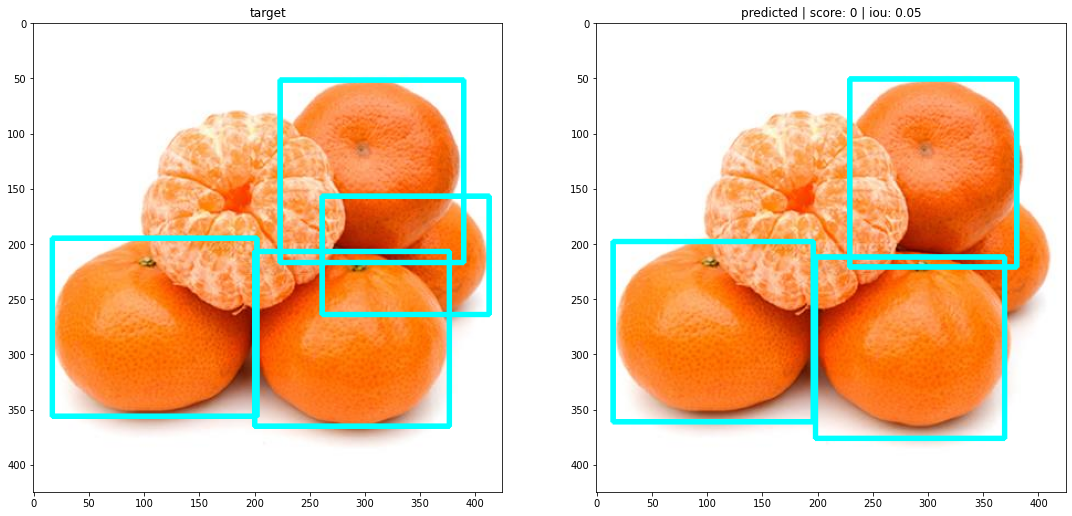

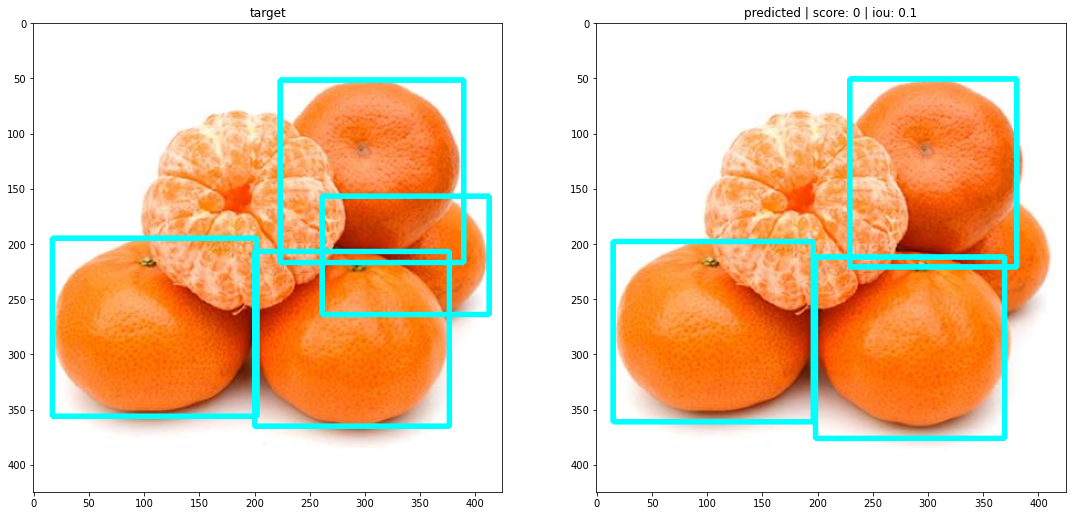

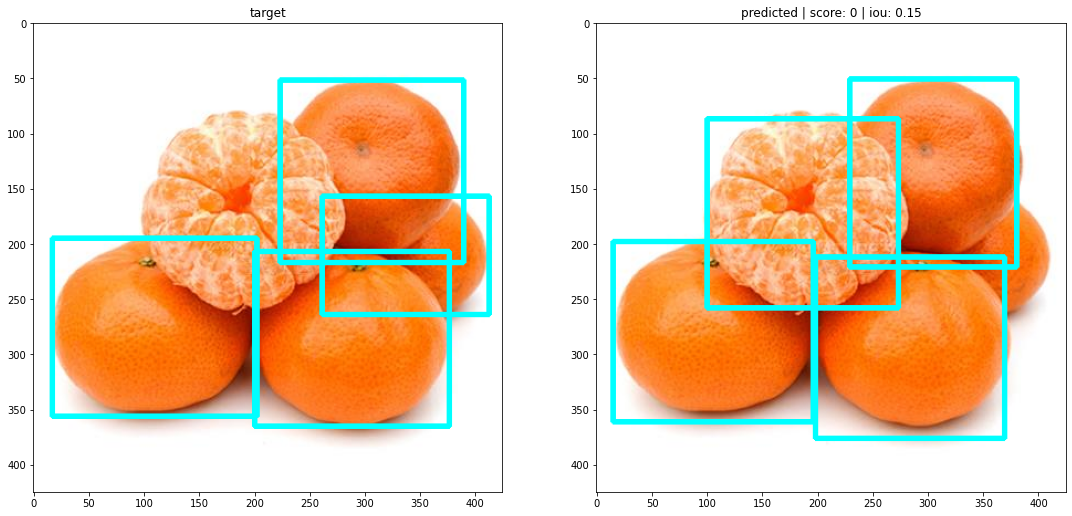

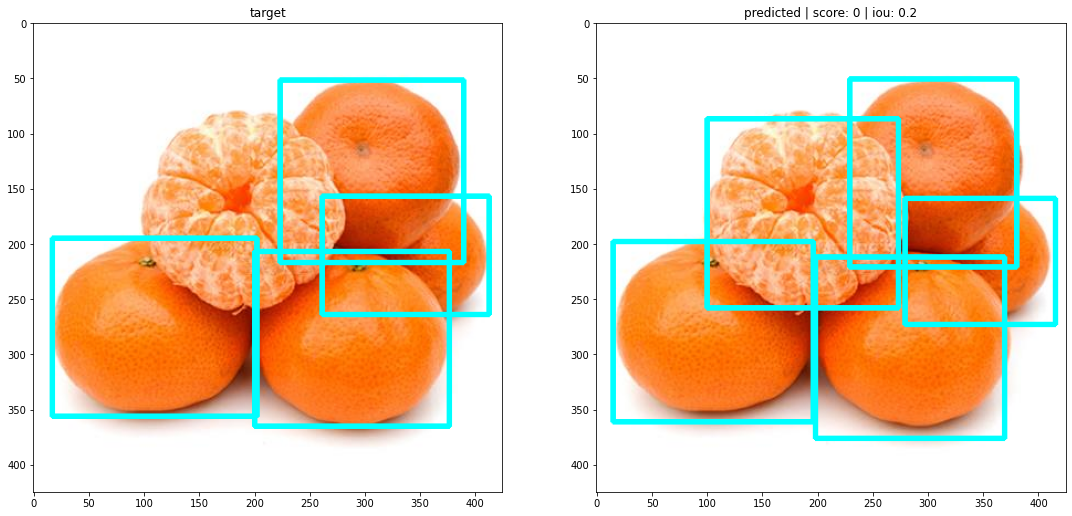

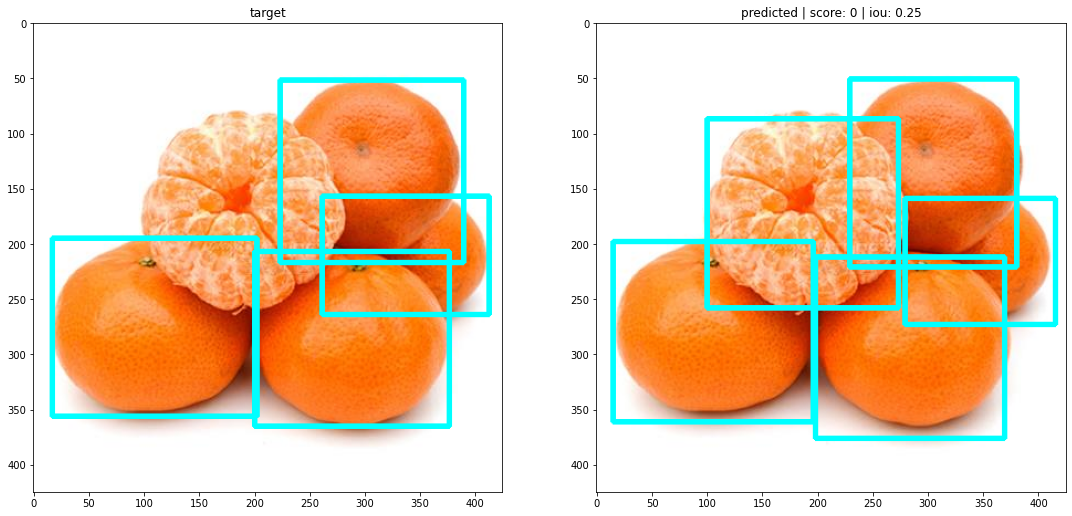

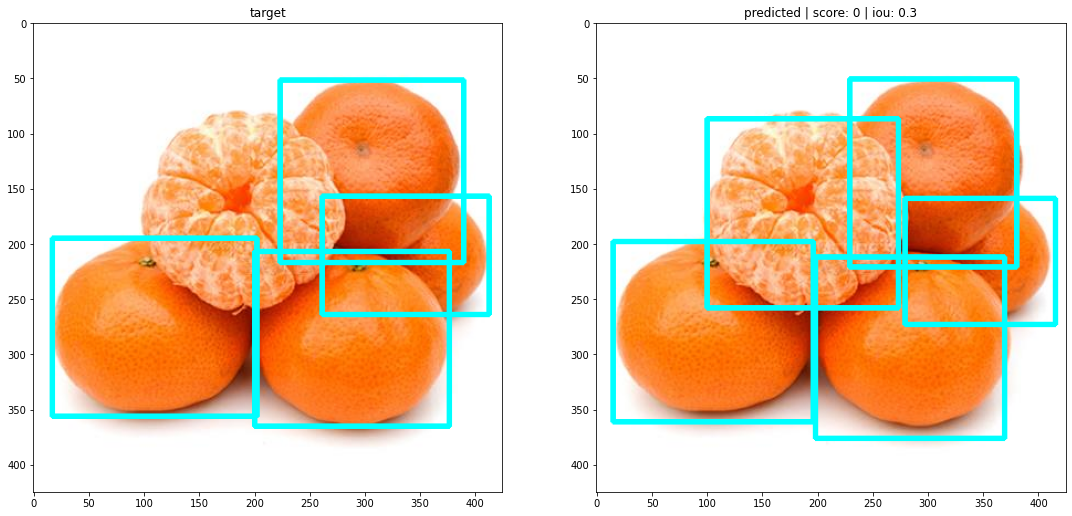

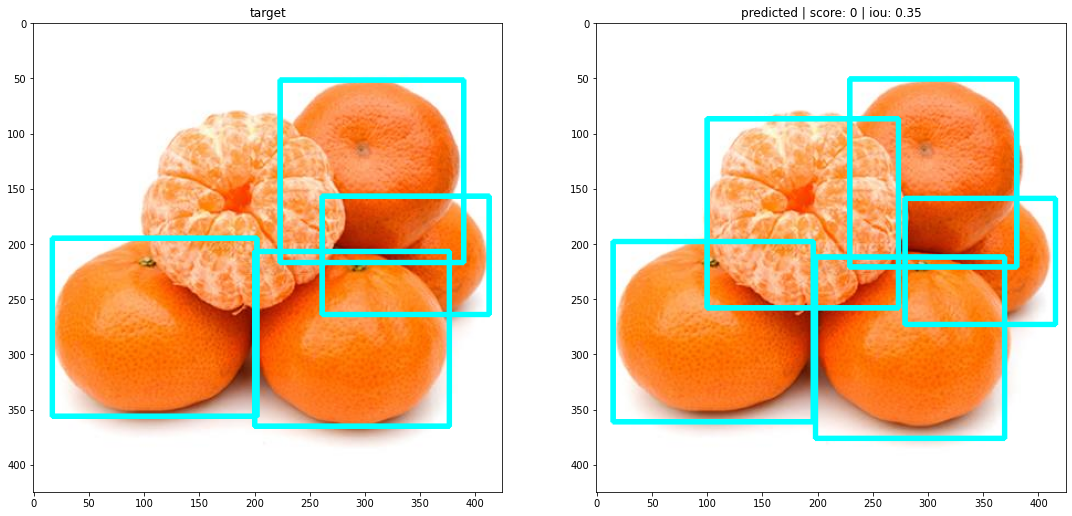

In [210]:
for z in range(0, 40, 5):
    watch_predict(model, i=5, ds=ds_test, score=0, iou_tresh=z/100, perform_nms=True)

**Фильтр работает очень хорошо и очищает картинку от лишних боксов**

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

### Задание 2

In [215]:
all_classes_different = {"apple": 1, "orange": 2, "banana": 3}

In [216]:
ds_train_all = FruitDataset("train", all_classes_different, transform)
train_size = round(len(ds_train_all)*0.75)
val_size = len(ds_train_all) - train_size
print(val_size, train_size)

ds_val, ds_train = random_split(ds_train_all, [val_size, train_size])
ds_test = FruitDataset("test", all_classes_different, transform)

60 180


In [254]:
batch_size=1

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=lambda data: tuple(zip(*data)))
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, collate_fn=lambda data: tuple(zip(*data)))
dl_test = DataLoader(ds_test, batch_size=batch_size, collate_fn=lambda data: tuple(zip(*data)))

Epoch: 0 / 3 | Auc: 0.847993631988173  |  Loss: 0.7506315112113953
Epoch: 1 / 3 | Auc: 0.865734478638284  |  Loss: 0.9821992516517639
Epoch: 2 / 3 | Auc: 0.8234700959804281  |  Loss: 1.0276631116867065
AUC = 0.8723936170121372


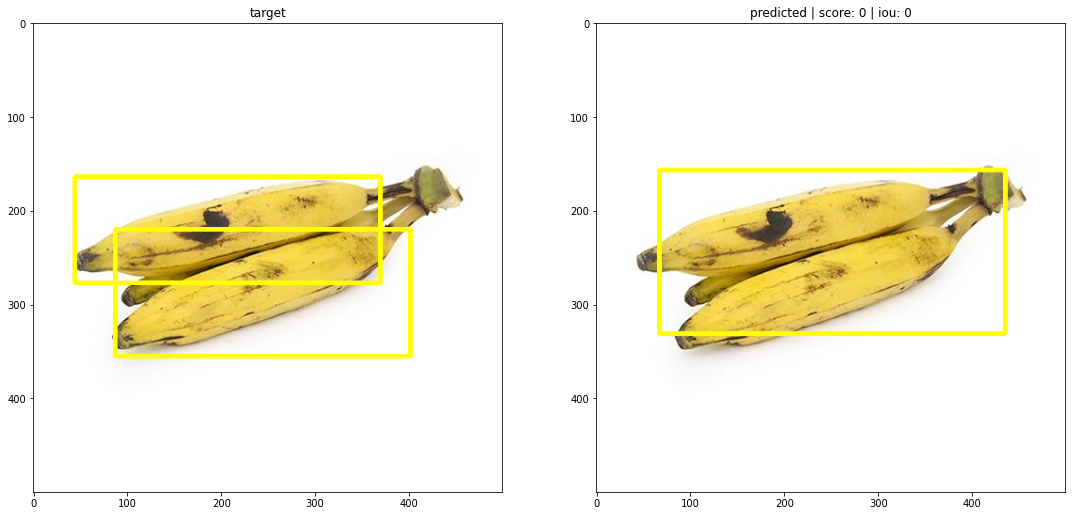

Epoch: 0 / 3 | Auc: 0.18393520273519862  |  Loss: 0.4403586685657501
Epoch: 1 / 3 | Auc: 0.3650225222019197  |  Loss: 1.2385324239730835
Epoch: 2 / 3 | Auc: 0.5838808500550812  |  Loss: 0.6307932138442993
AUC = 0.5740648362410052


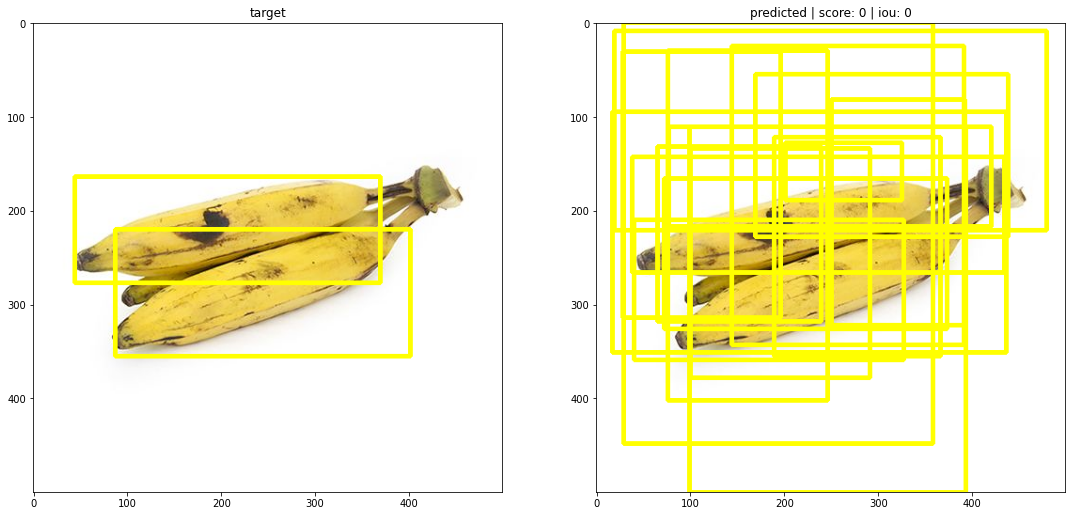

In [257]:
compare_pretrained_and_not_models("faster_rcnn", num_classes=4)

In [259]:
compare_pretrained_and_not_models("retina", lr=0.00001, num_classes=4)

IndexError: list index out of range

In [ ]:
compare_pretrained_and_not_models("ssd", lr=0.005, num_classes=4)

Epoch: 0 / 3 | Auc: 0.2786494607602622  |  Loss: 4.329280376434326


### Задание 3

In [ ]:
model = get_model(name="faster_rcnn", num_classes=2, pretrained=True, add_new_head=True)
train_model(model, num_epochs=6)

In [ ]:
for i in [0, 0.25, 0.5, 0.75, 1]:
    print(evaluate(model, dl_test, device, i))
    watch_predict(model, im=ds_test[5][0], boxes=ds_test[5][1]["boxes"], score=0, iou_tresh=i)

In [ ]:
for i in [0, 0.25, 0.5, 0.75, 1]:
    watch_predict(model, im=ds_test[5][0], boxes=ds_test[5][1]["boxes"], score=i, iou_tresh=0)

### Задание 4

In [ ]:
for i in range(10, 12):
    watch_predict(model, im=ds_test[i][0], boxes=ds_test[i][1]["boxes"], score=0, iou_tresh=0)

In [ ]:
im = cv2.cvtColor(cv2.imread("caf5e74ebb8ce12af51fd48ddd8614848ea429f4.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [ ]:
im = cv2.cvtColor(cv2.imread("IMG_8048.JPG"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [ ]:
im = cv2.cvtColor(cv2.imread("983794168.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [ ]:
im = cv2.cvtColor(cv2.imread("293773.png"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

In [ ]:
im = cv2.cvtColor(cv2.imread("oranges-apelsiny-na-vetke.jpg"), cv2.COLOR_BGR2RGB)
im = transform(im)
im = draw_bboxes(im, model([im.to(device)])[0]["boxes"], scores=None, score=None)
plt.show(plt.imshow(im))

### Задание 5

In [ ]:
for z in range(0, 40, 5):
    watch_predict(model, i=5, ds=ds_test, score=0, iou_tresh=z/100, perform_nms=True)

<br>  
<br>  
  
## Часть 3.  
  
*Вес в общей оценке - 0.2*  
  
Обучите модель для object detection для трех классов на __обучающем__ датасете и добейтесь PR AUC не менее __0.91__ на  __тестовом__.  
Баллы за задание вычисляются по формуле: __min(2, 2 * Ваш auc / 0.91)__.

In [246]:
good_model = get_model(name="faster_rcnn", num_classes=4, pretrained=True, add_new_head=True)
train_model(good_model, num_epochs=6)

Epoch: 0 / 6 | Auc: 0.8272755772394986  |  Loss: 1.223164677619934
Epoch: 1 / 6 | Auc: 0.8399441734068005  |  Loss: 0.4999672770500183
Epoch: 2 / 6 | Auc: 0.8282288972819423  |  Loss: 0.5327043533325195
Epoch: 3 / 6 | Auc: 0.893914129677976  |  Loss: 0.6889798641204834
Epoch: 4 / 6 | Auc: 0.8688682326435003  |  Loss: 1.1202046871185303
Epoch: 5 / 6 | Auc: 0.8855576334250456  |  Loss: 0.7273341417312622


In [ ]:
for i in range(10):
    watch_predict(good_model, ds=ds_test, i=i, score=0, iou_tresh=0)

<br>  
<br>  
  
## Бонусные задания.  
  
1. При обучении используйте аугментации (в первую очередь пространственные) из [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) или [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html).  
2. Возьмите одну из [детекционных архитектур](https://paperswithcode.com/sota/object-detection-on-coco) (желательно, не старее 2020 года), у которой выложены тренировочный код и чекпоинты на гитхабе, обучите и провалидируйте ее на данных этой лабораторной. 